# Analysis of the Berka dataset
http://lisp.vse.cz/pkdd99/berka.htm

In [2]:
%pylab inline
import pandas as pd
import pickle
import os
from datetime import date
from scipy import sparse, io

Populating the interactive namespace from numpy and matplotlib


In [2]:
def parse_dataset():
    for filename in os.listdir('original'):
        with open('original/' + filename, 'r') as input_file, open('parsed/' + filename.split('.')[0] + '.csv', 'w') as output_file:
            for line in input_file.readlines():
                print(line.replace('"', '').replace('\n', '').replace(';', ', ').replace(' ', ''), file=output_file)

In [3]:
if not os.path.isdir("parsed"):
    os.mkdir("parsed")
    parse_dataset()

## Transactions
We are interested in the actual transactions, so we'll analyze the trans.csv file

In [22]:
df = pd.read_csv('parsed/trans.csv')
print(df.head())
print(df.shape)
print(df.info())

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


   trans_id  account_id    date    type operation  amount  balance k_symbol  \
0    695247        2378  930101  PRIJEM     VKLAD   700.0    700.0      NaN   
1    171812         576  930101  PRIJEM     VKLAD   900.0    900.0      NaN   
2    207264         704  930101  PRIJEM     VKLAD  1000.0   1000.0      NaN   
3   1117247        3818  930101  PRIJEM     VKLAD   600.0    600.0      NaN   
4    579373        1972  930102  PRIJEM     VKLAD   400.0    400.0      NaN   

  bank  account  
0  NaN      NaN  
1  NaN      NaN  
2  NaN      NaN  
3  NaN      NaN  
4  NaN      NaN  
(1056320, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056320 entries, 0 to 1056319
Data columns (total 10 columns):
trans_id      1056320 non-null int64
account_id    1056320 non-null int64
date          1056320 non-null int64
type          1056320 non-null object
operation     873206 non-null object
amount        1056320 non-null float64
balance       1056320 non-null float64
k_symbol      521006 non-n

### Number of transactions per account
We group the accounts and check the number of transactions for each account

In [5]:
df_tc = df.groupby('account_id', as_index=False).size().rename('transaction_count').reset_index()
df_tc['transaction_count'].describe()

count    4500.000000
mean      234.737778
std       126.849443
min         9.000000
25%       133.000000
50%       208.000000
75%       330.000000
max       675.000000
Name: transaction_count, dtype: float64

We have 4500 accounts, with the 25th percentile being at 133 transactions per account. We take only the accounts from the 25th percentile to the 100th

In [6]:
account_id_list = df_tc[df_tc['transaction_count'] >= 133]['account_id'].tolist()
print('75% of transactions are in', len(account_id_list), 'accounts')

75% of transactions are in 3381 accounts


### Dates used
We now check when the starting and ending date of the transactions is

In [7]:
print('Total days with transactions:', len(df[df['account_id'].isin(account_id_list)]['date'].unique()))
min_date = df['date'].min()
max_date = df['date'].max()
print('Start:', min_date)
print('End:', max_date)

Total days with transactions: 2191
Start: 930101
End: 981231


This means that the average 234 transactions are over 2200 days, only the 11% is covered

### Analysis of the transactions

In [4]:
transactions = np.load("usable/transactions.npy")
transactions.shape

(4500, 2190)

In [5]:
print('mean', np.mean(transactions))
print('min', np.min(transactions))
print('max', np.max(transactions))

mean 56.72091
min -87400.0
max 74812.0


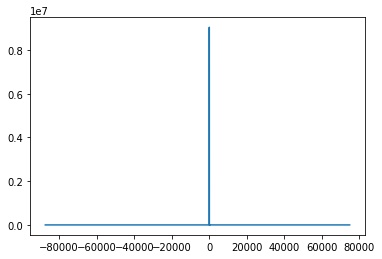

In [6]:
unique_items, counts = np.unique(np.array(transactions), return_counts=True)
plt.plot(unique_items, counts)

0 is the value that occurs almost everytime

values with highest count: [    0.    -14.6   -30.  -2400.  -1800. ] [9044551   73907    4230    3631    3399]


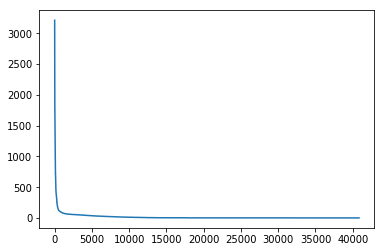

In [7]:
sorted_indexes = np.argsort(-counts)
counts = counts[sorted_indexes]
unique_items = unique_items[sorted_indexes]

print('values with highest count:', unique_items[:5], counts[:5])
plt.plot(counts[5:])

The values still follow a standard Zipf's distribution, but the bad thing is that is extremely heavy tailed

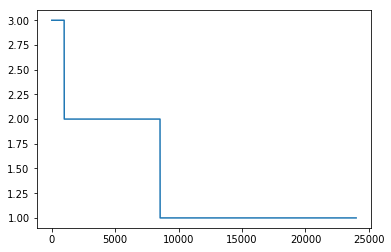

In [8]:
plt.plot(counts[-24000:])

We have around 10k values appearing only once